# Summation Error: Naive Algorithm

Suppose we are computing $\sum_{i=1}^n a_i$ on the computer, by the most simple method.  How does the accumulated roundoff error grow with $n$?

In [1]:
function mysum(a)
    s = zero(eltype(a))
    for x in a
        s += x
    end
    return s
end

mysum (generic function with 1 method)

In [2]:
a = rand(Float32, 1000)
mysum(a) - sum(Float64.(a))

-0.0002663135528564453

In [3]:
using PyPlot

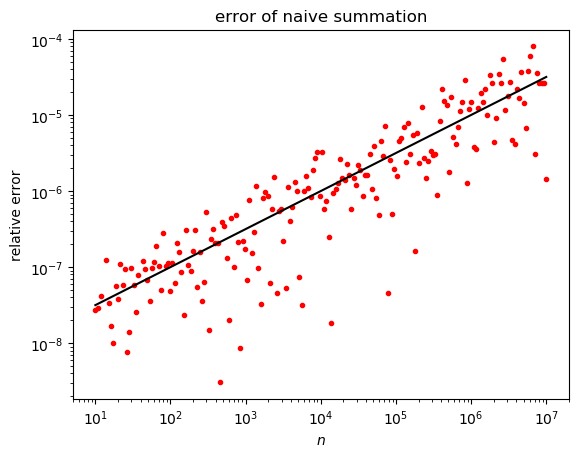

PyObject Text(0.5,1,'error of naive summation')

In [10]:
n = unique!(round.(Int, 10 .^ range(1,stop=7,length=200)))
err = [ let a=rand(Float32,n), exact = sum(Float64.(a))
            abs((mysum(a) - exact) / exact)
        end
        for n in n ]
loglog(n, err, "r.")
loglog(n, sqrt.(n) * 1e-8, "k-")
ylabel("relative error")
xlabel(L"n")
title("error of naive summation")

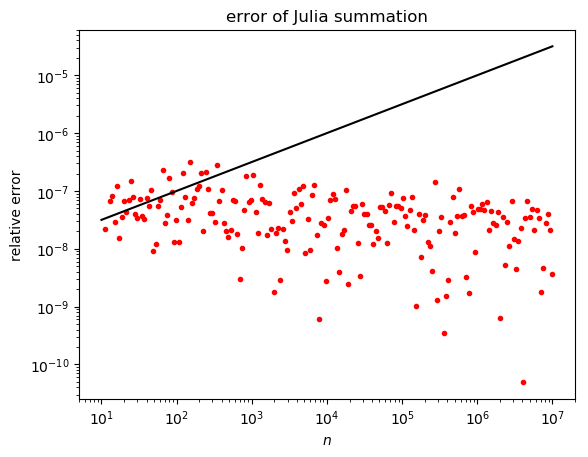

PyObject Text(0.5,1,'error of Julia summation')

In [11]:
n = unique!(round.(Int, 10 .^ range(1,stop=7,length=200)))
err = [ let a=rand(Float32,n), exact = sum(Float64.(a))
            abs((sum(a) - exact) / exact)
        end
        for n in n ]
loglog(n, err, "r.")
loglog(n, sqrt.(n) * 1e-8, "k-")
ylabel("relative error")
xlabel(L"n")
title("error of Julia summation")

# Random walks

The floating point errors in naive summation act like $n$ random numbers ±ε that are added up, where ε is the machine precision (the "accuracy" of the basic arithmetic operations).  This process is called a **random walk**.

In [12]:
eps(Float32)

1.1920929f-7

Let's generate $n$ random numbers of $\pm 1/n$ and look at what happens as we accumulate them:

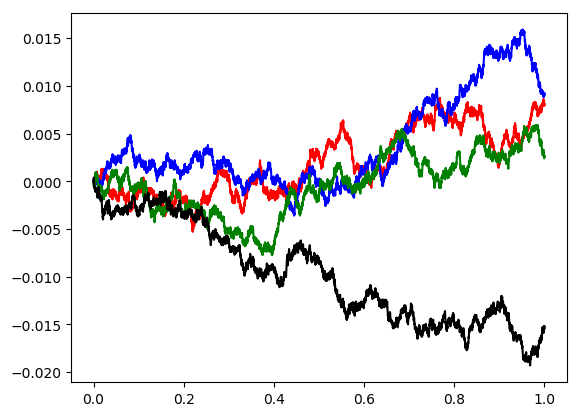

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x147dcdc50>

In [22]:
n = 10^4
plot(range(0,stop=1,length=n), cumsum(rand(-1:2:1, n) / n), "r-")
plot(range(0,stop=1,length=n), cumsum(rand(-1:2:1, n) / n), "b-")
plot(range(0,stop=1,length=n), cumsum(rand(-1:2:1, n) / n), "g-")
plot(range(0,stop=1,length=n), cumsum(rand(-1:2:1, n) / n), "k-")

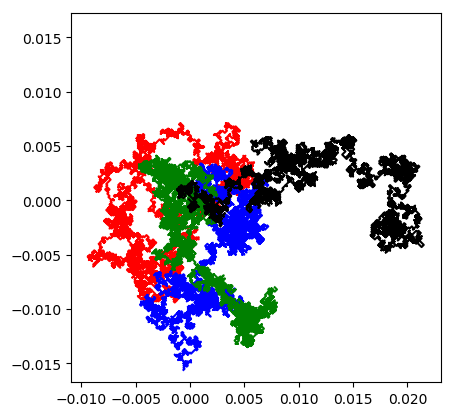

(-0.010945, 0.023045000000000006, -0.016735000000000007, 0.017255)

In [30]:
n = 10^4
plot(cumsum(rand(-1:2:1, n) / n), cumsum(rand(-1:2:1, n) / n), "r-")
plot(cumsum(rand(-1:2:1, n) / n), cumsum(rand(-1:2:1, n) / n), "b-")
plot(cumsum(rand(-1:2:1, n) / n), cumsum(rand(-1:2:1, n) / n), "g-")
plot(cumsum(rand(-1:2:1, n) / n), cumsum(rand(-1:2:1, n) / n), "k-")
axis("square")

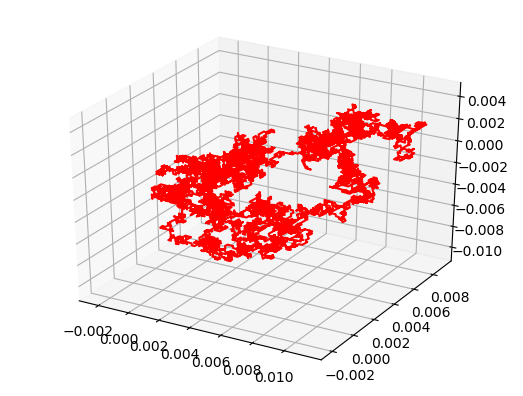

1-element Array{PyCall.PyObject,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x147d44198>

In [31]:
n = 10^4
plot3D(cumsum(rand(-1:2:1, n) / n), cumsum(rand(-1:2:1, n) / n), cumsum(rand(-1:2:1, n) / n), "r-")

There is a famous result that the root-mean-square (rms) distance from the origin is
$$
\sigma \sqrt{n}
$$
where $n$ is the number of steps and $\sigma = \sqrt{E(X^2)}$ is the root-mean-square of a single step $X$.

Above, $\sigma = 1/n$, so the rms distance grows as $\sqrt{1/n}$.

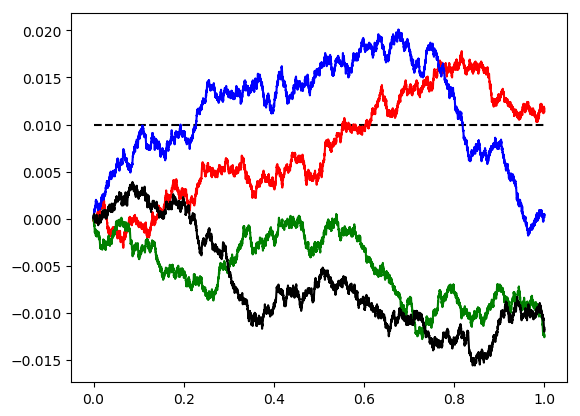

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13da0d240>

In [33]:
n = 10^4
plot([0,1], [1,1]/sqrt(n), "k--")
plot(range(0,stop=1,length=n), cumsum(rand(-1:2:1, n) / n), "r-")
plot(range(0,stop=1,length=n), cumsum(rand(-1:2:1, n) / n), "b-")
plot(range(0,stop=1,length=n), cumsum(rand(-1:2:1, n) / n), "g-")
plot(range(0,stop=1,length=n), cumsum(rand(-1:2:1, n) / n), "k-")

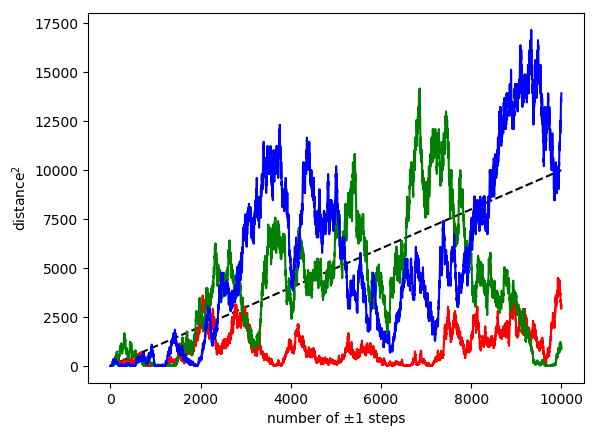

PyObject Text(0.5,24,'number of ±1 steps')

In [40]:
n = 10^4
N = 1:n
plot(N, N, "k--")
plot(N, cumsum(rand(-1:2:1, n)).^2, "r-")
plot(N, cumsum(rand(-1:2:1, n)).^2, "g-")
plot(N, cumsum(rand(-1:2:1, n)).^2, "b-")
ylabel(L"\mathrm{distance}^2")
xlabel("number of ±1 steps")

# Pairwise summation

A much more accurate way to sum $n$ numbers is to do [pairwise summation](https://en.wikipedia.org/wiki/Pairwise_summation): recursively break the array into halves and sum the two halves (with a base case of a naive sum when the array is sufficiently small):

In [81]:
@views function pairwisesum(a)
    n = length(a)
    if n < 256
        return mysum(a)
    else
        n2 = n ÷ 2 # div(n, 2)
        return pairwisesum(a[1:n2]) + pairwisesum(a[n2+1:n])
    end
end

pairwisesum (generic function with 1 method)

In [77]:
a = rand(1000)
pairwisesum(a) - mysum(a)

-1.7053025658242404e-13

In [78]:
using BenchmarkTools

In [82]:
a = rand(10^6)
@btime sum($a)
@btime mysum($a)
@btime pairwisesum($a)

  256.734 μs (0 allocations: 0 bytes)
  1.118 ms (0 allocations: 0 bytes)
  1.219 ms (8190 allocations: 383.91 KiB)


499848.1676885092

In [94]:
# sum(a[i1:i2]):
function pairwisesum2(a, i1=firstindex(a), i2=lastindex(a))
    n = i2 - i1 + 1
    if n < 1024
        s = zero(eltype(a))
        @simd for i = i1:i2
            @inbounds s += a[i]
        end
        return s
    else
        n2 = n ÷ 2 # div(n, 2)
        return pairwisesum2(a, i1, i1+n2-1) + pairwisesum2(a, i1+n2, i2)
    end
end

pairwisesum2 (generic function with 3 methods)

In [86]:
pairwisesum2(a) - sum(a)

0.0

In [95]:
a = rand(10^6)
@btime sum($a)
@btime mysum($a)
@btime pairwisesum($a)
@btime pairwisesum2($a)

  244.325 μs (0 allocations: 0 bytes)
  1.184 ms (0 allocations: 0 bytes)
  1.220 ms (8190 allocations: 383.91 KiB)
  244.504 μs (0 allocations: 0 bytes)


499786.2710779689

In [93]:
@which sum(a)

sum(a::AbstractArray) in Base at reducedim.jl:645

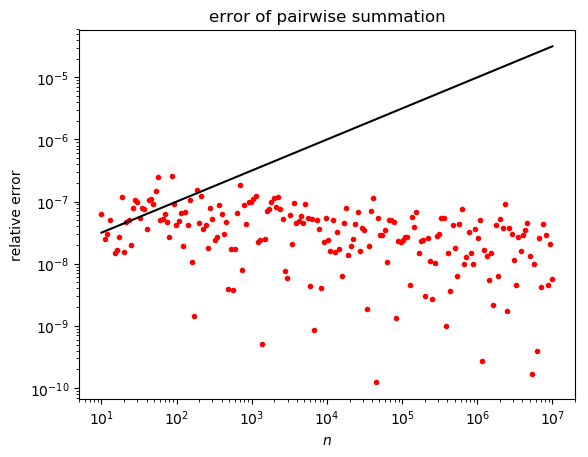

PyObject Text(0.5,1,'error of pairwise summation')

In [96]:
n = unique!(round.(Int, 10 .^ range(1,stop=7,length=200)))
err = [ let a=rand(Float32,n), exact = sum(Float64.(a))
            abs((pairwisesum2(a) - exact) / exact)
        end
        for n in n ]
loglog(n, err, "r.")
loglog(n, sqrt.(n) * 1e-8, "k-")
ylabel("relative error")
xlabel(L"n")
title("error of pairwise summation")

In fact, the pairwise summation algorithm has amazingly slow error growth.  Its root mean square (rms) error grows as:
$$
\varepsilon \sqrt{\log n}
$$
where ε is the precision and $n$ is the number of summands.
